In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import requests
import seaborn as sns
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import ensemble
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

In [2]:
#url='https://www.kaggle.com/kemical/kickstarter-projects/downloads/ks-projects-201801.csv'
#df=pd.read_csv(url, header=None)

In [3]:
df = pd.read_csv('ks-projects-201801.csv',error_bad_lines=False)

b'Skipping line 20454: expected 15 fields, saw 19\nSkipping line 27266: expected 15 fields, saw 23\nSkipping line 47738: expected 15 fields, saw 19\nSkipping line 54556: expected 15 fields, saw 23\n'
b'Skipping line 75000: expected 15 fields, saw 17\nSkipping line 95465: expected 15 fields, saw 21\nSkipping line 102283: expected 15 fields, saw 26\nSkipping line 129576: expected 15 fields, saw 26\n'
b'Skipping line 170525: expected 15 fields, saw 16\nSkipping line 177348: expected 15 fields, saw 26\n'
b'Skipping line 204638: expected 15 fields, saw 19\nSkipping line 211470: expected 15 fields, saw 26\nSkipping line 218306: expected 15 fields, saw 16\nSkipping line 252430: expected 15 fields, saw 17\nSkipping line 259262: expected 15 fields, saw 26\n'
b'Skipping line 266098: expected 15 fields, saw 18\nSkipping line 300233: expected 15 fields, saw 17\nSkipping line 307065: expected 15 fields, saw 27\nSkipping line 313893: expected 15 fields, saw 19\n'
b'Skipping line 348033: expected 15 

https://www.kaggle.com/kromel/kickstarter-successful-vs-failed/data

In [4]:
df=df.sample(1000, random_state=32)

In [5]:
df.shape

(1000, 15)

In [6]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
711859,292924641,"NextGen, Use any platform on any devive, rules...",Software,Technology,SEK,2014-11-04,50000,2014-10-21 15:14:46,0,failed,0,SE,0,0.00,6726.22
443026,1865145137,Cassidy Jones Adventures: Paperback Books For ...,Fiction,Publishing,USD,2012-07-12,1000,2012-06-28 01:35:01,1505,successful,43,US,1505,1505.00,1000.00
305960,1549399998,· Guenda · products for connecting with nature...,Embroidery,Crafts,MXN,2017-12-25,60000.00,2017-11-25 15:56:14,60520.00,successful,84,MX,112.64,3067.57,3041.21
56190,1111918633,The ABCs of Nightmares,Children's Books,Publishing,CAD,2016-11-24,8500.00,2016-10-24 01:05:08,2764.00,failed,49,CA,0,2048.77,6300.50
867977,7.40164e+08,The Toughest,Documentary,Film & Video,USD,2016-04-02,2295.00,2016-03-03 15:46:40,0.00,failed,0,US,0,0.00,2295.00


In [7]:
df.dtypes

ID                   object
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                 object
launched             object
pledged              object
state                object
backers              object
country              object
usd pledged          object
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

# Data Cleaning

### Nulls

In [8]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
df_missingData = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
display(df_missingData.head(20))
df.isnull().sum().max()

,Total,Percent
usd pledged,8,0.008
usd_goal_real,0,0.000
usd_pledged_real,0,0.000
country,0,0.000
backers,0,0.000
state,0,0.000
pledged,0,0.000
launched,0,0.000
goal,0,0.000
deadline,0,0.000


8

In [9]:
dfNoNulls = df.copy()
dfNoNulls.dropna(inplace=True)
print ("Before Dropping Nulls: ", df.shape[0])
print ("After Dropping Nulls: ", dfNoNulls.shape[0])
print ("Rows Removed: ", df.shape[0] - dfNoNulls.shape[0])
print ("Percent Removed: {:.0%}".format(1-(dfNoNulls.shape[0])/df.shape[0]))   

Before Dropping Nulls:  1000
After Dropping Nulls:  992
Rows Removed:  8
Percent Removed: 1%


### "usd pledged" Column: Bad Formatting

In [10]:
dfDropPldg = dfNoNulls.copy()
for row in dfDropPldg.iterrows():
    if str(row[1]['usd pledged']).count('.') > 1:
        print (row)
        dfDrop = dfDropPldg.drop(row[0])
        break;
# Use a comprehension for this

In [11]:
dfDropCntry = dfDropPldg.copy()
dfDropCntry = dfDropCntry.drop(dfDropCntry[(dfDropCntry['country'] != 'US')].index)

In [12]:
dfDropCat = dfDropCntry.copy()
dfDropCat = dfDropCat.drop('category',axis=1)

In [13]:
dfDropState = dfDropCat.copy()
dropVals = ['live','suspended','canceled','fnceled']
for dv in dropVals:
    dfDropState = dfDropState.drop(dfDropState[(dfDropState['state'] == dv)].index)

### Convert to Numeric

In [14]:
dfNum = dfDropState.copy()
numCols = ['goal','pledged','backers','usd pledged']
for c in numCols:
    dfNum[c] = dfNum[c].apply(pd.to_numeric)

In [15]:
dfNum.describe()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,7.000000e+02,700.000000,700.000000,700.000000,700.000000,7.000000e+02
mean,2.324955e+04,8470.745529,120.361429,6414.505000,8470.745529,2.324955e+04
std,1.286013e+05,31772.481735,492.706359,27647.878257,31772.481735,1.286013e+05
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000,1.000000e+00
25%,2.000000e+03,81.000000,3.000000,35.000000,81.000000,2.000000e+03
50%,5.000000e+03,1102.500000,20.000000,802.000000,1102.500000,5.000000e+03
75%,1.500000e+04,5208.500000,71.000000,4067.750000,5208.500000,1.500000e+04
max,3.000000e+06,588903.000000,9677.000000,588903.000000,588903.000000,3.000000e+06


# Encoding

In [16]:
sorted(dfNum.state.unique())

['failed', 'successful']

In [17]:
dfEnc = pd.DataFrame()
dfEnc = dfNum.copy()
dfEnc['state'] = dfNum.state.astype('category')
dfEnc['state_code'] = np.where(dfEnc['state'].str.contains('successful'),1,0)

In [18]:
dfEnc = pd.get_dummies(dfEnc, columns=['main_category'], prefix = ['cat'])

In [19]:
dfEnc.shape

(700, 29)

In [20]:
dfEnc.reset_index(inplace=True, drop=True)

# Helper Functions

In [21]:
def BoxHist(column, df_focus):
    
    sns.set()
    colList = df_focus[column]
    
    # plots
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(y=column, data=df_focus)
    
    plt.subplot(1, 2, 2)
    g=sns.distplot(colList, kde=False, bins=60)
    
    # rotate label for large tick values on histagram x axis
    if (colList.max() > 9999):
        plt.setp(g.get_xticklabels(), rotation=45)

    plt.show()

In [52]:
def loopIterations2(X,y,listOfCs,verbose=False):

    for c in listOfCs:

        IterRdgLr = LogisticRegression(C=c, penalty='l2').fit(X,y)
        score = IterRdgLr.score(X,y)
        cvs = cross_val_score(IterRdgLr, X,y, cv=5)
        # Display.
        if verbose:
            print('===========================')
        print("C:{0}\n Score:{1}".format(c,score))
        print (" CVS:\n  {}".format(cvs))
        if verbose:
            print('Coefficients:')
            print(IterRdgLr.coef_)
            print('Intercept:')
            print(IterRdgLr.intercept_)

            pred_y_sklearn = IterRdgLr.predict(X)
            print('Accuracy CrossTab:')
            print(pd.crosstab(pred_y_sklearn, y))

# Isolate the Issue Columns

In [53]:
dfIsolate = dfEnc[['state_code','goal','pledged','backers']].copy()

# Many Outliers

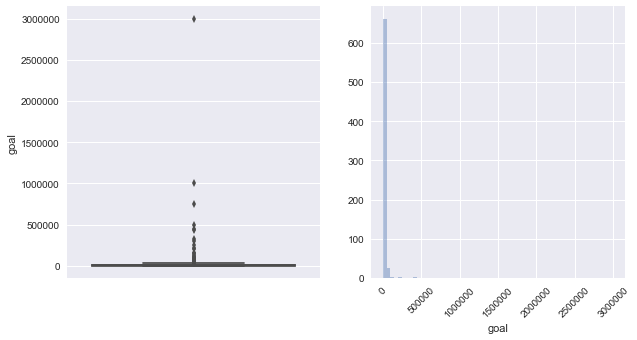

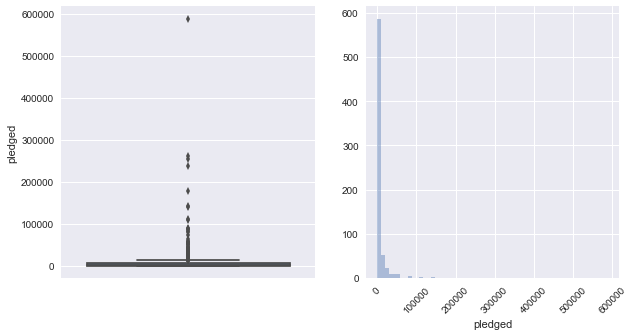

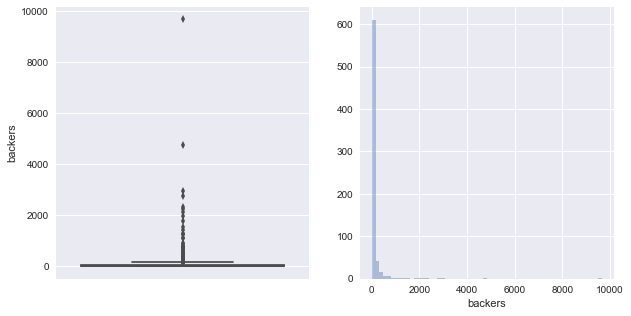

In [54]:
contCols = ['goal','pledged','backers']
for col in contCols:
    BoxHist(col,dfIsolate)

# Weak Correlation

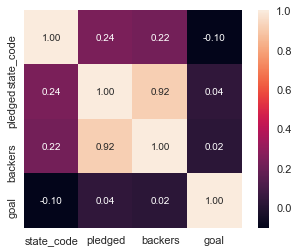

In [55]:
corrmat = dfIsolate.corr()
k = 10
cols = corrmat.nlargest(k, 'state_code')['state_code'].index
cm = np.corrcoef(dfIsolate[cols].values.T)
sns.set(font_scale=1.1)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Set Target and Data

In [56]:
X = dfIsolate.drop('state_code', axis=1)
y = dfIsolate['state_code']

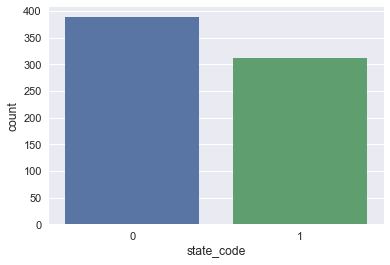

In [57]:
sns.countplot(x=y,data=dfNum)
plt.show()

# Issue

The Cross Val results for LogisticRegression are returning the same values regardless of the regularization parameter "C".

In [60]:
B_rdgLr3 = LogisticRegression(C=300, penalty='l2').fit(X,y)
print('300\t' + str(B_rdgLr3.score(X,y)))

    
B_rdgLr5 = LogisticRegression(C=.003, penalty='l2').fit(X,y)
print('.003\t' + str(B_rdgLr5.score(X,y)))

    
B_rdgLr5 = LogisticRegression(C=.00003, penalty='l2').fit(X,y)
print('.00003\t' + str(B_rdgLr5.score(X,y)))

300	1.0
.003	1.0
.00003	1.0


In [61]:
listOfCs = [300,.003,.00003,.0000000003]
loopIterations2(X,y,listOfCs, verbose=True)

C:300
 Score:1.0
 CVS:
  [ 1.          1.          1.          1.          0.99280576]
Coefficients:
[[-0.04378602  0.05157578  0.00363444]]
Intercept:
[ 0.0004377]
Accuracy CrossTab:
state_code    0    1
row_0               
0           388    0
1             0  312
C:0.003
 Score:1.0
 CVS:
  [ 1.          1.          1.          1.          0.99280576]
Coefficients:
[[-0.03895599  0.04591977  0.00316042]]
Intercept:
[ 0.00039138]
Accuracy CrossTab:
state_code    0    1
row_0               
0           388    0
1             0  312
C:3e-05
 Score:1.0
 CVS:
  [ 1.          1.          1.          1.          0.99280576]
Coefficients:
[[-0.01216908  0.01433618  0.00060847]]
Intercept:
[  5.95852113e-05]
Accuracy CrossTab:
state_code    0    1
row_0               
0           388    0
1             0  312
C:3e-10
 Score:0.99
 CVS:
  [ 0.9858156   0.9929078   1.          0.98561151  0.98561151]
Coefficients:
[[ -9.13474754e-05   1.33276603e-04   2.01389078e-06]]
Intercept:
[ -1.75825355e-

## Remove Goal Outliers

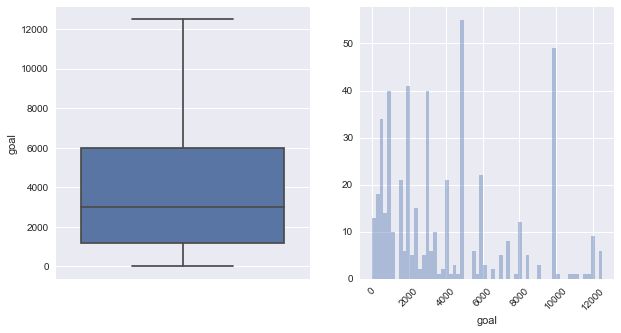

(502, 4)

In [30]:
dfNoGoalOutlier = dfEnc[['state_code','goal','pledged','backers']].copy()
#dfNoGoalOutlier = dfNoGoalOutlier[np.abs(dfNoGoalOutlier.goal-dfNoGoalOutlier.goal.mean()) <= (3*dfNoGoalOutlier.goal.std())]

dfNoGoalOutlier = dfNoGoalOutlier[dfNoGoalOutlier.goal < dfNoGoalOutlier.goal.quantile(.72)]

BoxHist('goal',dfNoGoalOutlier)
plt.show()

dfNoGoalOutlier.shape

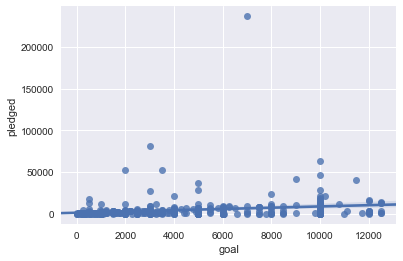

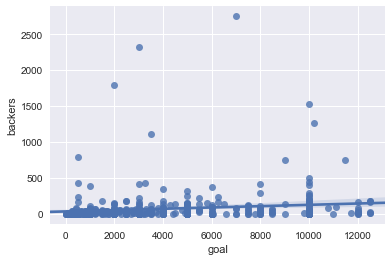

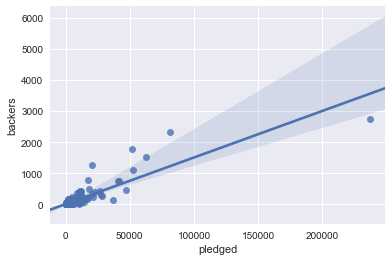

In [31]:
graphlog = []
for colx in ['goal','pledged','backers']:
    for coly in ['goal','pledged','backers']:
        logItem = coly+colx
        if (colx != coly) & (colx+coly not in graphlog):
            ax = sns.regplot(x=colx,y=coly, data=dfNoGoalOutlier)
            graphlog.append(coly+colx)
            plt.show()

## Remove Pledge Outliers

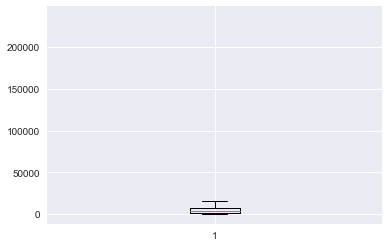

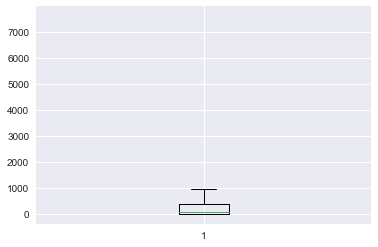

In [32]:
plt.boxplot(dfNoGoalOutlier[dfNoGoalOutlier['state_code']==1]['pledged'])
  #           ,dfCorr[dfCorr['state']==0]['goal']])
plt.show()

plt.boxplot(dfNoGoalOutlier[dfNoGoalOutlier['state_code']==0]['pledged'])
  #           ,dfCorr[dfCorr['state']==0]['goal']])
plt.show()

In [33]:
dfNoGoalOutlier['pledged'].describe()

count       502.000000
mean       4033.503745
std       12950.928828
min           0.000000
25%          80.250000
50%        1005.500000
75%        3702.500000
max      236949.000000
Name: pledged, dtype: float64

In [34]:
dfNoPledgeOutlier = dfNoGoalOutlier.copy()
#dfNoPledgeOutlier = dfNoPledgeOutlier[np.abs(dfNoPledgeOutlier.goal-dfNoPledgeOutlier.goal.mean()) <= (3*dfNoPledgeOutlier.goal.std())]

dfNoPledgeOutlier = dfNoPledgeOutlier[dfNoPledgeOutlier.goal < dfNoPledgeOutlier.goal.quantile(.00155)]

In [35]:
dfNoPledgeOutlier.shape

(1, 4)

In [36]:
pledgeNoZero = dfNoGoalOutlier.copy()
pledgeNoZero = pledgeNoZero[dfNoGoalOutlier.pledged > 200 ]